# LLM - Bielik - Fine tuning - part II

## Introduction 

This is second part of small series related to LLM fine-tuning!

The goal of following article is to fine-tuning one large language model - Bielik 7B from Speakleash <page>. In first part <link to first part> we focused on data preparation. To achieve this, we generated data based on the polish legal document. Then, we measured the quality of the generated data using various metrics (distance and LLM based). As we proved the good quality of the generated question and answers based on the context, we formatted the data in order to follow a specific schema suitable for question-answering task for LLM.

Now let's dive deep into the fine-tuning itself!


# Prerequisites

In order to start working with model and finetuning let's install required libraries (also present in requirements.txt). Short intro to libraries:
- bitandbytes - setups config for quantization options
- transformers - core library for using Large Language Models and beyond
- accelerate - <em>Accelerate is a library that enables the same PyTorch code to be run across any distributed configuration by adding just four lines of code.</em> https://huggingface.co/docs/accelerate/en/index
- peft - our gem! <strong>P</strong>aremeter-<strong>E</strong>fficient <strong>F</strong>ine <strong>T</strong>uning library which allows to finetune small number of extra model paremeters instead of all which could be costly.
- wandb - weights and biases - useful for tracking the experiments (https://wandb.ai/site/)
- torch, torchvision, torchaudio - core PyTorch libraries for running neural networks.

In [1]:
# ! pip install bitsandbytes
# ! pip install transformers
# ! pip install accelerate
# ! pip install peft
# ! pip install wandb
# ! pip install datasets
# ! pip install ipywidgets==8.1.3
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, logging
import transformers
from datetime import datetime
from accelerate import Accelerator
from huggingface_hub import notebook_login
from peft import prepare_model_for_kbit_training, PeftModel, LoraConfig, get_peft_model
from src.helpers.models import load_model
from src.helpers.data import load_data, generate_and_tokenize, plot_hist, generate_and_tokenize_with_truncation
from src.data.val_dataset import get_validation_dataset
import seaborn as sns
from pypalettes import load_cmap
from src.inference.generation import generate

In [2]:
%load_ext autoreload
%autoreload 2

## 3...2...1...action!
Let's start with some helper functions:
- setting appropriate level of logging, because pytorch likes to spam all the output console.
- login to huggingface with credentials to be able to download some models - not every model is available without logging in.

In [2]:
logging.set_verbosity_warning()
notebook_login()

To start with, let's focus on our model. Here, we want to load and setup appropriate model, Bielik 7B in our case. We start with quantization config in order to make our model lighter. Then we use a helper function to get the model from HuggingFace Hub.

In [3]:
model_config = {
        'load_in_4bit':True,
        'bnb_4bit_use_double_quant':True,
        'bnb_4bit_quant_type':"nf4",
        'bnb_4bit_compute_dtype':torch.bfloat16
}

model_name = 'speakleash/Bielik-7B-v0.1'

In [4]:
model, tokenizer = load_model(model_name, config=model_config)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Having the model and aligned tokenizer loaded, let's head to data. In previous part of this tutorial we focused on generating data, questions and answers, to use for training the model specific task like handling user questions. Now, we need to split our data for training and evaluation set. Here, we did this process manually, by spliting the dataset and creating two separate files - training and eval. In this case around 80% is training dataset and around 20% is eval dataset.

In [5]:
train_data_path = 'ft_output_data/data_ft_20240818_133719_train.jsonl'
eval_data_path = 'ft_output_data/data_ft_20240818_133719_eval.jsonl'

In [6]:
train_dataset = load_data(path=train_data_path, type='train', format='json')
eval_dataset = load_data(path=eval_data_path, type='train', format='json')

After loading the data to an specific format suitable for fine-tuning, we need to preprocess the input data to be used for QA task. Our data now will have format as follows: "### Question: <question>\n ### Answer: <answer>}". It will be also tokenized (transformed from words to numbers).

In [7]:
tokenized_train_dataset = train_dataset.map(lambda x: generate_and_tokenize(prompt=x, tokenizer=tokenizer))
tokenized_eval_dataset = eval_dataset.map(lambda x: generate_and_tokenize(prompt=x, tokenizer=tokenizer))

Let us verify how long our sentences are. In the first part of article about data generation, we asked GPT model to deliver answers with a limit of 200 tokens. We set this limit to instruct the model to provide concise answer within this number. Combining questions and answers gives us numbers as below:

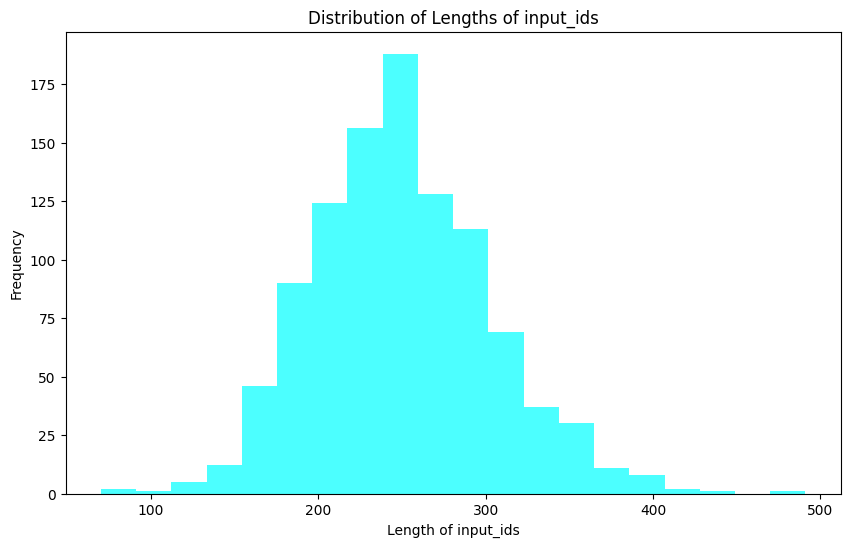

In [8]:
plot_hist(tokenized_train_dataset, tokenized_eval_dataset)

As shown, the majority of sentences are between 200 and 300 tokens in length. Now, for model usage we need to make all the sentences mand make them the same size and if the sentence is shorter we add padding.

In [9]:
max_length = 512

In [10]:
tokenized_train_dataset = train_dataset.map(lambda x: generate_and_tokenize_with_truncation(prompt=x, tokenizer=tokenizer, length=max_length))
tokenized_val_dataset = eval_dataset.map(lambda x: generate_and_tokenize_with_truncation(prompt=x, tokenizer=tokenizer, length=max_length))

Map:   0%|          | 0/225 [00:00<?, ? examples/s]

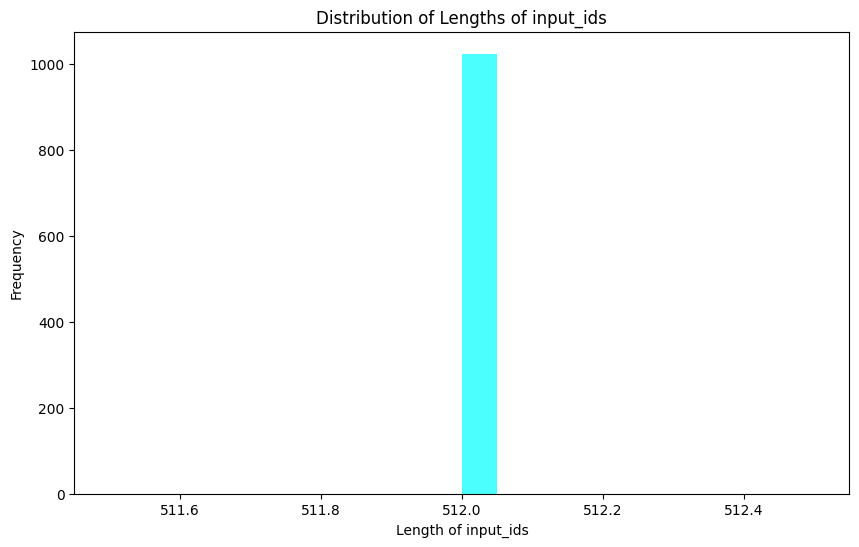

In [11]:
plot_hist(tokenized_train_dataset, tokenized_val_dataset)

For comparison results between non-finetuned model and finetuned one, the validation dataset is created with selected questions related to the topic of consumer rights. Questions and groundtruth answers come from https://prawakonsumenta.uokik.gov.pl/pytania-i-odpowiedzi/zagadnienia-ogolne/ . We switched the source of questions in order to avoid data leakage (using train / eval dataset questions from earlier prepared data). This dataset is not verbose, it contains only 11 questions, but at this point should be enough to verify if the fine-tuning worked. Let's set our baseline here:

In [5]:
val_dataset = get_validation_dataset()
val_dataset

,question,groundtruth
0,Kiedy jestem konsumentem?,Konsument to osoba fizyczna dokonująca z przed...
1,"Czy jestem konsumentem, gdy kupuję towar od os...","Nie jesteś konsumentem, gdy kupujesz towar od ..."
2,Co oznacza wyraźna zgoda na dodatkową płatność...,Wyraźną zgodę wyraża sam konsument. Nie można ...
3,Czy przedsiębiorca może dowolnie ustalać koszt...,"Nie, przedsiębiorca nie może ustalać tego w sp..."
4,Czy przy zakupie biletu do teatru obowiązują p...,"Tak, przepisy ustawy o prawach konsumenta stos..."
5,Kiedy jest niedozwolona odsprzedaż konsumentom...,Niedozwolona jest odsprzedaż konsumentom bilet...
6,Kiedy podwójna jakość produktów jest niezgodna...,Niezgodne z prawem jest wprowadzenie na polski...
7,Czy do umów o najem i rezerwację miejsc parkin...,"Tak, w przypadku tego typu umów stosuje się us..."
8,Czy sprzedawca może przenieść na konsumenta od...,Przedsiębiorca nie może przenieść na konsument...
9,Czy konsument może żądać od sprzedawcy potwier...,Jeżeli przedsiębiorca proponuje konsumentowi z...


In [7]:
val_dataset['baseline_model_response'] = val_dataset['question'].apply(lambda x: generate(model_name=model_name, model=model, text=x))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\models\mistral\modeling_mistral.py:647: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end gen

In [8]:
val_dataset

,question,groundtruth,baseline_model_response
0,Kiedy jestem konsumentem?,Konsument to osoba fizyczna dokonująca z przed...,Kiedy jestem konsumentem?\nKiedy nie prowadzę ...
1,"Czy jestem konsumentem, gdy kupuję towar od os...","Nie jesteś konsumentem, gdy kupujesz towar od ...","Czy jestem konsumentem, gdy kupuję towar od os..."
2,Co oznacza wyraźna zgoda na dodatkową płatność...,Wyraźną zgodę wyraża sam konsument. Nie można ...,Co oznacza wyraźna zgoda na dodatkową płatność...
3,Czy przedsiębiorca może dowolnie ustalać koszt...,"Nie, przedsiębiorca nie może ustalać tego w sp...",Czy przedsiębiorca może dowolnie ustalać koszt...
4,Czy przy zakupie biletu do teatru obowiązują p...,"Tak, przepisy ustawy o prawach konsumenta stos...",Czy przy zakupie biletu do teatru obowiązują p...
5,Kiedy jest niedozwolona odsprzedaż konsumentom...,Niedozwolona jest odsprzedaż konsumentom bilet...,Kiedy jest niedozwolona odsprzedaż konsumentom...
6,Kiedy podwójna jakość produktów jest niezgodna...,Niezgodne z prawem jest wprowadzenie na polski...,Kiedy podwójna jakość produktów jest niezgodna...
7,Czy do umów o najem i rezerwację miejsc parkin...,"Tak, w przypadku tego typu umów stosuje się us...",Czy do umów o najem i rezerwację miejsc parkin...
8,Czy sprzedawca może przenieść na konsumenta od...,Przedsiębiorca nie może przenieść na konsument...,Czy sprzedawca może przenieść na konsumenta od...
9,Czy konsument może żądać od sprzedawcy potwier...,Jeżeli przedsiębiorca proponuje konsumentowi z...,Czy konsument może żądać od sprzedawcy potwier...


In [19]:
model.gradient_checkpointing_enable() # -> this speeds up training on single GPU
model = prepare_model_for_kbit_training(model) # -> prepares model for training, exact operations: This method wraps the entire protocol for preparing a model before running a training. This includes: 1- Cast the layernorm in fp32 2- making output embedding layer require grads 3- Add the upcasting of the lm head to fp32.

## Model fine-tuning

At first, create our LORA config. Lora stands for Low-Rank Adaptation which breaks down the original model matrix into the two smaller ones, which drastically reduces the number of parameters which needs to be trained, maintaining quality and efficiency. The most important parameters we will take into consideration is R and alpha. R, for Rank, will determine how many trainable parameters we will train and alpha will determine how much focus we should put on new learned weights, Lora paper suggest that alpha should be 2x Rank. According to FartyPants (yeah, really - https://medium.com/@fartypantsham/what-rank-r-and-alpha-to-use-in-lora-in-llm-1b4f025fd133) we should be careful with this parameters as there is a chance that our model base capabilities will be devoured by new ones. 

In [20]:
from src.helpers.models import print_trainable_parameters

In [21]:
lora_params = {
    'r': 64,
    'alpha': 128,
    'layers': ["q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            "lm_head"],
    'dropout': 0.05
}

use_linear_layers = False
linear_layers = ['gate_proj', 'down_proj', 'up_proj', 'q_proj', 'v_proj', 'k_proj','o_proj']

config = LoraConfig(
    r=lora_params.get('r'),
    lora_alpha=lora_params.get('alpha'),
    target_modules=lora_params.get('layers') if not use_linear_layers else linear_layers,
    bias="none",
    lora_dropout=lora_params.get('dropout'),  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 170082304 || all params: 3922153472 || trainable%: 4.336452033664837


In [22]:
accelerator = Accelerator()
model = accelerator.prepare_model(model)

## Training


Here, we are using some additional setup for tracking any experiments. We are using weights and biases as an experiment tracker. 

In [23]:
project = "legal-finetune"
base_model_name = "bielik_v1"
params = f'r-{lora_params.get("r")}-alpha-{lora_params.get("alpha")}'
run_name = base_model_name + "-" + project + "-" + params
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, 
        bf16=True,
        optim="sgd",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        
        save_strategy="steps",       
        save_steps=25,                
        evaluation_strategy="steps", 
        eval_steps=25,               
        do_eval=True,                
        report_to="wandb",           
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False
trainer.train()

C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\transformers\training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs
wandb: Currently logged in as: zvit3k (zvit3k-kodio). Use `wandb login --relogin` to force relogin


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]


Step,Training Loss,Validation Loss
25,1.075900,1.020677
50,1.033500,1.016016
75,1.069400,1.010600
100,1.044600,1.004614
125,1.039500,0.998606
150,1.036500,0.993411
175,0.993500,0.986732
200,1.042000,0.983343
225,0.991500,0.979121
250,1.024800,0.974872


C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\peft\utils\save_and_load.py:202: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\_dynamo\eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
C:\Users\zjada\dev\projects\llm-bielik-ft-legal\venv\lib\site-packages\torch\utils\checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torc

TrainOutput(global_step=500, training_loss=1.01540193939209, metrics={'train_runtime': 1249.4976, 'train_samples_per_second': 0.8, 'train_steps_per_second': 0.4, 'total_flos': 2.23440742121472e+16, 'train_loss': 1.01540193939209, 'epoch': 1.25})

In [3]:
base_model_id = "speakleash/Bielik-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

In [4]:
ft_model = PeftModel.from_pretrained(base_model, "bielik_v1-legal-finetune-r-64-alpha-128/checkpoint-500")

In [3]:
val_dataset = pd.read_csv('data/data_to_eval.csv', sep='|', index_col=0)
val_dataset

,question,groundtruth,baseline_model_response,finetuned_model_response,finetuned_500_model_response,finetuned_500_model_response_r64_a128,finetuned_500_model_response_r64_a128_multinomial,finetuned_500_model_response_r64_a128_beam_search_multinomial,finetuned_500_model_response_r64_a128_beam_search
Unnamed: 0,,,,,,,,,
0,Kiedy jestem konsumentem?,Konsument to osoba fizyczna dokonująca z przed...,Kiedy jestem konsumentem?\nKiedy nie prowadzę ...,Kiedy jestem konsumentem?\nKonsument to osoba ...,Kiedy jestem konsumentem? Czyli o prawach kons...,Kiedy jestem konsumentem?\nKiedy nie prowadzę ...,Kiedy jestem konsumentem? Zgodnie z art. 221 K...,Kiedy jestem konsumentem? Ustawa o ochronie ni...,Kiedy jestem konsumentem? Konsument to osoba f...
1,"Czy jestem konsumentem, gdy kupuję towar od os...","Nie jesteś konsumentem, gdy kupujesz towar od ...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os..."
2,Co oznacza wyraźna zgoda na dodatkową płatność...,Wyraźną zgodę wyraża sam konsument. Nie można ...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...
3,Czy przedsiębiorca może dowolnie ustalać koszt...,"Nie, przedsiębiorca nie może ustalać tego w sp...",Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...
4,Czy przy zakupie biletu do teatru obowiązują p...,"Tak, przepisy ustawy o prawach konsumenta stos...",Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...
5,Kiedy jest niedozwolona odsprzedaż konsumentom...,Niedozwolona jest odsprzedaż konsumentom bilet...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...
6,Kiedy podwójna jakość produktów jest niezgodna...,Niezgodne z prawem jest wprowadzenie na polski...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...
7,Czy do umów o najem i rezerwację miejsc parkin...,"Tak, w przypadku tego typu umów stosuje się us...",Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...
8,Czy sprzedawca może przenieść na konsumenta od...,Przedsiębior

In [27]:
generation_params = {
    'config_name': 'multinomial',
    'max_new_tokens': 512,
    'sampling': True,
    'n_beams':1,
    'top_k':25
}

# generation_params = {
#     'config_name': 'beam_search_multinomial',
#     'max_new_tokens': 512,
#     'sampling': True,
#     'n_beams':4,
#     'top_k':25
# }

# generation_params = {
#     'config_name': 'beam_search',
#     'max_new_tokens': 512,
#     'sampling': False,
#     'n_beams':5,
#     'top_k': None
# }

output_col_name = f'finetuned_500_model_response_r64_a128_{generation_params.get("config_name")}'

In [28]:
val_dataset[output_col_name] = val_dataset['question'].apply(lambda x: generate(model_name=base_model_id, model=ft_model, text=x, generation_params=generation_params))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for o

In [35]:
val_dataset

,Unnamed: 0,question,groundtruth,baseline_model_response,finetuned_model_response,finetuned_500_model_response,finetuned_500_model_response_r64_a128,finetuned_500_model_response_r64_a128_multinomial,finetuned_500_model_response_r64_a128_beam_search_multinomial,finetuned_500_model_response_r64_a128_beam_search
0,0,Kiedy jestem konsumentem?,Konsument to osoba fizyczna dokonująca z przed...,Kiedy jestem konsumentem?\nKiedy nie prowadzę ...,Kiedy jestem konsumentem?\nKonsument to osoba ...,Kiedy jestem konsumentem? Czyli o prawach kons...,Kiedy jestem konsumentem?\nKiedy nie prowadzę ...,Kiedy jestem konsumentem? Zgodnie z art. 221 K...,Kiedy jestem konsumentem? Ustawa o ochronie ni...,Kiedy jestem konsumentem? Konsument to osoba f...
1,1,"Czy jestem konsumentem, gdy kupuję towar od os...","Nie jesteś konsumentem, gdy kupujesz towar od ...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os...","Czy jestem konsumentem, gdy kupuję towar od os..."
2,2,Co oznacza wyraźna zgoda na dodatkową płatność...,Wyraźną zgodę wyraża sam konsument. Nie można ...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...,Co oznacza wyraźna zgoda na dodatkową płatność...
3,3,Czy przedsiębiorca może dowolnie ustalać koszt...,"Nie, przedsiębiorca nie może ustalać tego w sp...",Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...,Czy przedsiębiorca może dowolnie ustalać koszt...
4,4,Czy przy zakupie biletu do teatru obowiązują p...,"Tak, przepisy ustawy o prawach konsumenta stos...",Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...,Czy przy zakupie biletu do teatru obowiązują p...
5,5,Kiedy jest niedozwolona odsprzedaż konsumentom...,Niedozwolona jest odsprzedaż konsumentom bilet...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...,Kiedy jest niedozwolona odsprzedaż konsumentom...
6,6,Kiedy podwójna jakość produktów jest niezgodna...,Niezgodne z prawem jest wprowadzenie na polski...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...,Kiedy podwójna jakość produktów jest niezgodna...
7,7,Czy do umów o najem i rezerwację miejsc parkin...,"Tak, w przypadku tego typu umów stosuje się us...",Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...,Czy do umów o najem i rezerwację miejsc parkin...
8,8,Czy sprzedawca może przenieść na konsumenta od...,Prz

In [29]:
val_dataset.to_csv('data/data_to_eval.csv', sep='|', index=0)

## Fine-tuning evaluation
As a final step, we will try to evaluate model answers by measuring the distance between base and fine-tuned model answers with the prepared groundtruth. For this task, we will use metrics created in first part of article when we measured distance for generated text using Word Mover Distance. In this case, we will enrich this comparison by introducing also well known metric - cosine similarity. 

In [31]:
data = val_dataset

In [7]:
from src.external_requests.openai_req import OpenAIReq
from src.external_requests.prompting import PromptBuilder

In [33]:
# groundtruth_results = data.copy()
# groundtruth_results['model_name'] = 'groundtruth'
# 
# baseline_model_results = data.copy()
# baseline_model_results['model_name'] = 'baseline'
# 
# finetuned_model_results = data.copy()
# finetuned_model_results['model_name'] = 'finetuned'

# finetuned_500_model_results = data.copy()
# finetuned_500_model_results['model_name'] = 'finetuned_500'

finetuned_500_model_results_r64_a128_multinomial = data.copy()
finetuned_500_model_results_r64_a128_multinomial['model_name'] = 'finetuned_500_r64_a128_multinomial'


finetuned_500_model_results_r64_a128_beam_search_multinomial = data.copy()
finetuned_500_model_results_r64_a128_beam_search_multinomial['model_name'] = 'finetuned_500_r64_a128_beam_search_multinomial'


finetuned_500_model_results_r64_a128_beam_search = data.copy()
finetuned_500_model_results_r64_a128_beam_search['model_name'] = 'finetuned_500_r64_a128_beam_search'

In [37]:
metric_name = 'coherence'

# groundtruth_results[metric_name] = groundtruth_results['groundtruth'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_coherence_pl(x)))
# 
# baseline_model_results[metric_name] = baseline_model_results['baseline_model_response'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_coherence_pl(x)))
# 
# finetuned_model_results[metric_name] = finetuned_model_results['finetuned_model_response'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_coherence_pl(x)))

# finetuned_500_model_results_r64_a128_multinomial[metric_name] = finetuned_500_model_results_r64_a128_multinomial['finetuned_500_model_response_r64_a128_multinomial'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_coherence_pl(x)))

# finetuned_500_model_results_r64_a128_beam_search_multinomial[metric_name] = finetuned_500_model_results_r64_a128_beam_search_multinomial['finetuned_500_model_response_r64_a128_beam_search_multinomial'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_coherence_pl(x)))

finetuned_500_model_results_r64_a128_beam_search[metric_name] = finetuned_500_model_results_r64_a128_beam_search['finetuned_500_model_response_r64_a128_beam_search'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_coherence_pl(x)))

In [8]:
import  json
def get_score(row: str) -> int:
    result = json.loads(row)
    score = result.get('score')
    return score

def get_explanation(row: str) -> str:
    result = json.loads(row)
    explanation = result.get('explanation')
    return explanation
    

In [39]:
# groundtruth_results['coherence_score'] = groundtruth_results[metric_name].apply(get_score)
# baseline_model_results['coherence_score'] = baseline_model_results[metric_name].apply(get_score)
# finetuned_model_results['coherence_score'] = finetuned_model_results[metric_name].apply(get_score)
#finetuned_500_model_results_r64_a128['coherence_score'] = finetuned_500_model_results_r64_a128[metric_name].apply(get_score)
finetuned_500_model_results_r64_a128_multinomial['coherence_score'] = finetuned_500_model_results_r64_a128_multinomial[metric_name].apply(get_score)
finetuned_500_model_results_r64_a128_beam_search_multinomial['coherence_score'] = finetuned_500_model_results_r64_a128_beam_search_multinomial[metric_name].apply(get_score)
finetuned_500_model_results_r64_a128_beam_search['coherence_score'] = finetuned_500_model_results_r64_a128_beam_search[metric_name].apply(get_score)


In [4]:
data_checkpoint_dir = 'checkpoints'

In [41]:
# groundtruth_results.to_csv(f'{data_checkpoint_dir}/groundtruth_results.csv', sep='|')
# baseline_model_results.to_csv(f'{data_checkpoint_dir}/baseline_model_results.csv', sep='|')
# finetuned_model_results.to_csv(f'{data_checkpoint_dir}/finetuned_model_results.csv', sep='|')
# finetuned_500_model_results_r64_a128.to_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_results.csv', sep='|')
finetuned_500_model_results_r64_a128_multinomial.to_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_multinomial_results.csv', sep='|')
finetuned_500_model_results_r64_a128_beam_search_multinomial.to_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_beam_search_multinomial_results.csv', sep='|')
finetuned_500_model_results_r64_a128_beam_search.to_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_beam_search_results.csv', sep='|')


In [5]:
groundtruth_results = pd.read_csv(f'{data_checkpoint_dir}/groundtruth_results.csv', sep='|')
baseline_model_results = pd.read_csv(f'{data_checkpoint_dir}/baseline_model_results.csv', sep='|')
finetuned_model_results = pd.read_csv(f'{data_checkpoint_dir}/finetuned_model_results.csv', sep='|')
finetuned_500_model_results_r64_a128 = pd.read_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_results.csv', sep='|')
finetuned_500_model_results_r64_a128_multinomial = pd.read_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_multinomial_results.csv', sep='|')
finetuned_500_model_results_r64_a128_beam_search_multinomial = pd.read_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_beam_search_multinomial_results.csv', sep='|')
finetuned_500_model_results_r64_a128_beam_search = pd.read_csv(f'{data_checkpoint_dir}/finetuned_500_model_results_r64_a128_beam_search_results.csv', sep='|')

In [9]:
metric_name = 'accuracy'

# groundtruth_results[metric_name] = groundtruth_results.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy(x['question'], x['groundtruth'])), axis=1)
# 
# baseline_model_results[metric_name] = baseline_model_results.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy(x['question'], x['baseline_model_response'])), axis=1)
# 
# finetuned_model_results[metric_name] = finetuned_model_results.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy(x['question'], x['finetuned_model_response'])), axis=1)

#finetuned_500_model_results_r64_a128[metric_name] = finetuned_500_model_results_r64_a128.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy(x['question'], x['finetuned_500_model_response_r64_a128'])))

finetuned_500_model_results_r64_a128_multinomial[metric_name] = finetuned_500_model_results_r64_a128_multinomial.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy(x['question'], x['finetuned_500_model_response_r64_a128_multinomial'])), axis=1)

finetuned_500_model_results_r64_a128_beam_search_multinomial[metric_name] = finetuned_500_model_results_r64_a128_beam_search_multinomial.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy(x['question'], x['finetuned_500_model_response_r64_a128_beam_search_multinomial'])), axis=1)

finetuned_500_model_results_r64_a128_beam_search[metric_name] = finetuned_500_model_results_r64_a128_beam_search.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_accuracy(x['question'], x['finetuned_500_model_response_r64_a128_beam_search'])), axis=1)

In [16]:
# groundtruth_results['accuracy_score'] = groundtruth_results[metric_name].apply(get_score)
# baseline_model_results['accuracy_score'] = baseline_model_results[metric_name].apply(get_score)
# finetuned_model_results['accuracy_score'] = finetuned_model_results[metric_name].apply(get_score)
# finetuned_500_model_results_r64_a128['accuracy_score'] = finetuned_500_model_results_r64_a128[metric_name].apply(get_score)
finetuned_500_model_results_r64_a128_multinomial['accuracy_score'] = finetuned_500_model_results_r64_a128_multinomial[metric_name].apply(get_score)
finetuned_500_model_results_r64_a128_beam_search_multinomial['accuracy_score'] = finetuned_500_model_results_r64_a128_beam_search_multinomial[metric_name].apply(get_score)
finetuned_500_model_results_r64_a128_beam_search['accuracy_score'] = finetuned_500_model_results_r64_a128_beam_search[metric_name].apply(get_score)

In [11]:
metric_name = 'clarity'

# groundtruth_results[metric_name] = groundtruth_results.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x['groundtruth'])), axis=1)
# 
# baseline_model_results[metric_name] = baseline_model_results.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x['baseline_model_response'])), axis=1)
# 
# finetuned_model_results[metric_name] = finetuned_model_results.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x['finetuned_model_response'])), axis=1)

# finetuned_500_model_results_r64_a128[metric_name] = finetuned_500_model_results_r64_a128.apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x['finetuned_500_model_response_r64_a128'])), axis=1)

finetuned_500_model_results_r64_a128_multinomial[metric_name] = finetuned_500_model_results_r64_a128_multinomial['finetuned_500_model_response_r64_a128_multinomial'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x)))

finetuned_500_model_results_r64_a128_beam_search_multinomial[metric_name] = finetuned_500_model_results_r64_a128_beam_search_multinomial['finetuned_500_model_response_r64_a128_beam_search_multinomial'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x)))

finetuned_500_model_results_r64_a128_beam_search[metric_name] = finetuned_500_model_results_r64_a128_beam_search['finetuned_500_model_response_r64_a128_beam_search'].apply(lambda x: OpenAIReq(model='gpt-4o').call_api_formatted(prompt=PromptBuilder.get_clarity_pl(x)))

In [12]:
# groundtruth_results['clarity_score'] = groundtruth_results[metric_name].apply(get_score)
# baseline_model_results['clarity_score'] = baseline_model_results[metric_name].apply(get_score)
# finetuned_model_results['clarity_score'] = finetuned_model_results[metric_name].apply(get_score)
#finetuned_500_model_results_r64_a128['clarity_score'] = finetuned_500_model_results_r64_a128[metric_name].apply(get_score)
finetuned_500_model_results_r64_a128_multinomial['clarity_score'] = finetuned_500_model_results_r64_a128_multinomial[metric_name].apply(get_score)

finetuned_500_model_results_r64_a128_beam_search_multinomial['clarity_score'] = finetuned_500_model_results_r64_a128_beam_search_multinomial[metric_name].apply(get_score)

finetuned_500_model_results_r64_a128_beam_search['clarity_score'] = finetuned_500_model_results_r64_a128_beam_search[metric_name].apply(get_score)

In [17]:
merged = pd.concat([groundtruth_results, baseline_model_results, finetuned_500_model_results_r64_a128, finetuned_500_model_results_r64_a128_multinomial, finetuned_500_model_results_r64_a128_beam_search_multinomial, finetuned_500_model_results_r64_a128_beam_search ])

In [18]:
melted = pd.melt(merged, id_vars=['model_name'], value_vars=['coherence_score','accuracy_score', 'clarity_score'])
melted

,model_name,variable,value
0,groundtruth,coherence_score,4
1,groundtruth,coherence_score,4
2,groundtruth,coherence_score,5
3,groundtruth,coherence_score,5
4,groundtruth,coherence_score,4
...,...,...,...
751,finetuned_500_r64_a128_beam_search,clarity_score,4
752,finetuned_500_r64_a128_beam_search,clarity_score,2
753,finetuned_500_r64_a128_beam_search,clarity_score,3
754,finetuned_500_r64_a128_beam_search,clarity_score,4


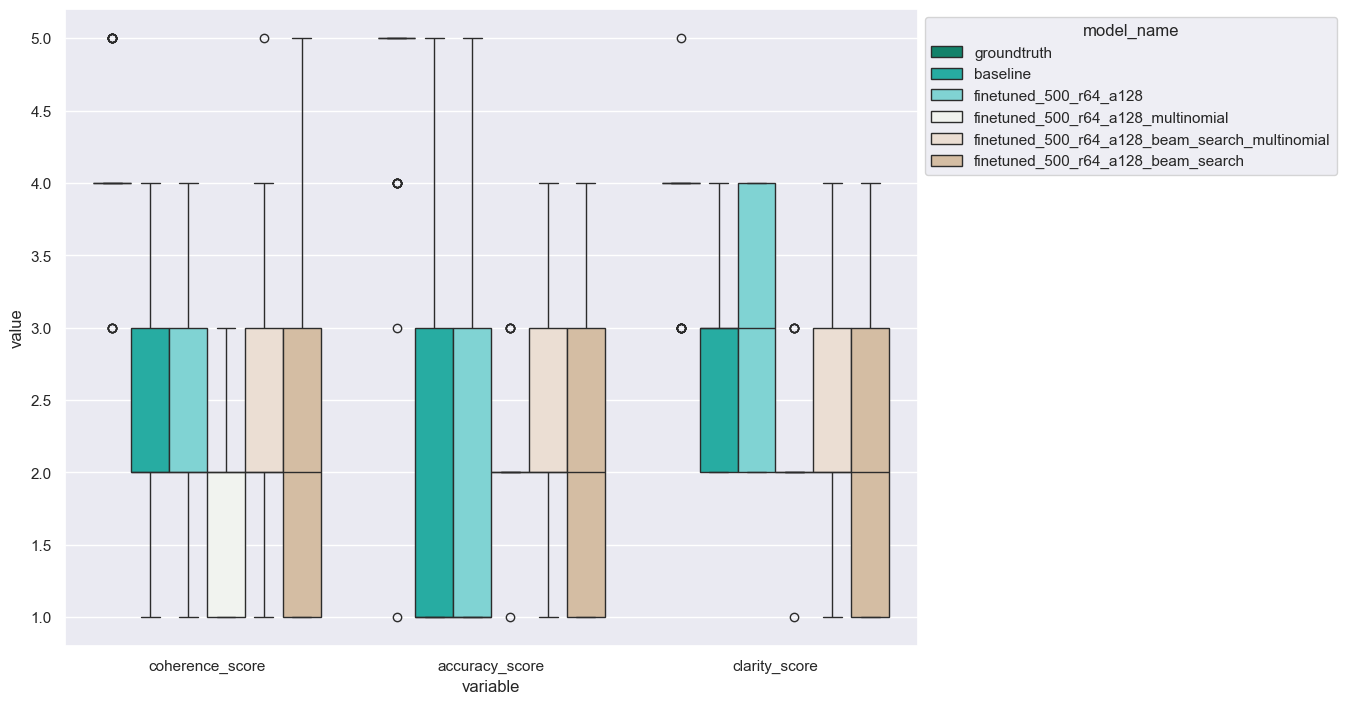

In [23]:
c_palette = load_cmap('Anemone',keep_first_n=6).hex
sns.set_theme(rc={'figure.figsize':(11,8.27)})

box_plot = sns.boxplot(melted, y='value', x='variable', hue='model_name', palette=c_palette)
sns.move_legend(box_plot, "upper left", bbox_to_anchor=(1, 1))